### Prof. Pedram Jahangiry

You need to make a copy to your own Google drive if you want to edit the original notebook! Start by opening this notebook on Colab 👇

<a href="https://colab.research.google.com/github/PJalgotrader/Deep_forecasting-USU/blob/main/Lectures%20and%20codes/Module%206-%20Deep%20Neural%20Networks/Module6_UnivariateTS_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



![logo](https://upload.wikimedia.org/wikipedia/commons/4/44/Huntsman-Wordmark-with-USU-Blue.gif#center)


## 🔗 Links

[![linkedin](https://img.shields.io/badge/LinkedIn-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pedram-jahangiry-cfa-5778015a)

[![Youtube](https://img.shields.io/badge/youtube_channel-1DA1F2?style=for-the-badge&logo=youtube&logoColor=white&color=FF0000)](https://www.youtube.com/channel/UCNDElcuuyX-2pSatVBDpJJQ)

[![Twitter URL](https://img.shields.io/twitter/url/https/twitter.com/PedramJahangiry.svg?style=social&label=Follow%20%40PedramJahangiry)](https://twitter.com/PedramJahangiry)


---


# Module 6- Deep Neural Networks with Tensorflow and Keras

# Installation

* If you want to run your code on Google Colab, there is no installation required. (recommended for the course)
* If you want to run your code locally, then you need to install tensorflow first: https://www.tensorflow.org/install


In [1]:
import tensorflow
tensorflow.__version__

'2.17.0'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/airline_passengers.csv", index_col="Month")
data.index = pd.to_datetime(data.index)
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Making supervised ML/DL data

In [4]:
test_period = 24
train_period = len(data) - test_period

print(f"Train period: {train_period}")
print(f"Test period: {test_period}")

Train period: 120
Test period: 24


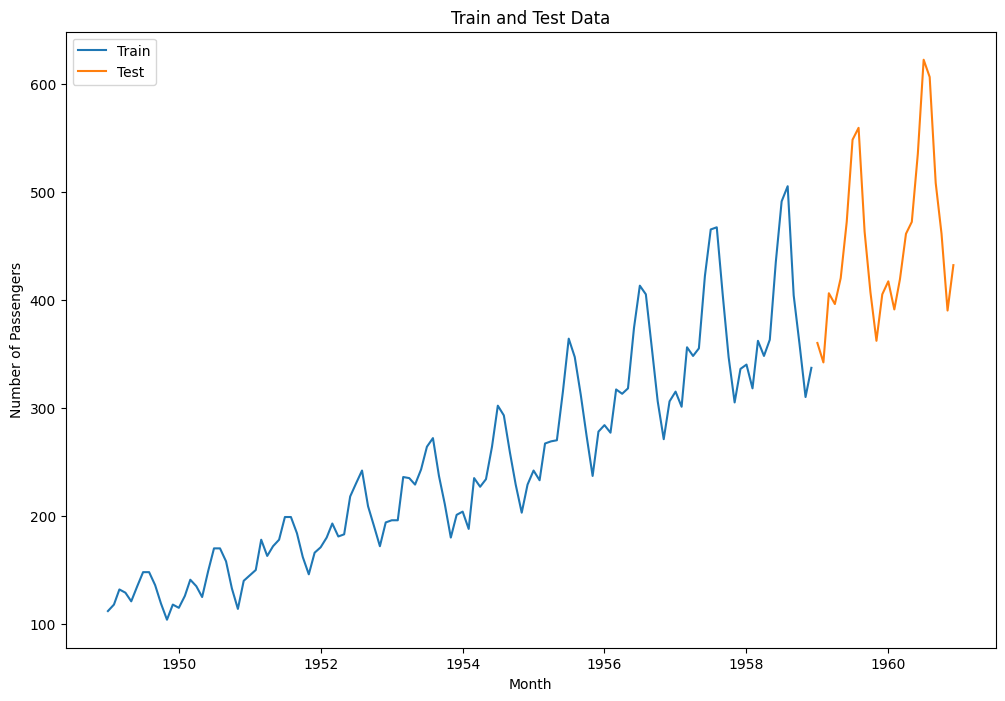

In [5]:
train = data.iloc[:train_period]
test = data.iloc[train_period:]

# plotting the train and test data with different colors
plt.figure(figsize=(12, 8))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.title('Train and Test Data')
plt.xlabel('Month')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

In [6]:
# A Boolean series indicating which rows of the DataFrame data belong to each set (train, test)
train_indicator = (data.index <= train.index[-1])
test_indicator =  (data.index > train.index[-1])

In [7]:
# creating feature space X and target variable y for the training and test datasets
series = data['Passengers'].dropna().to_numpy()

In [8]:
len(series)

144

In [9]:
Tx = 12 # Number of lags! using the past Tx observations to forecast the next one.
Ty = 1 #  Forecasting Ty outputs at once
X = np.array([series[t:t+Tx] for t in range(len(series) - Tx-Ty+1)])
Y = np.array([series[t+Tx: t+Tx+Ty] for t in range(len(series) - Tx-Ty+1)])
N = len(X)

print("X:", X.shape, "Y:", Y.shape, "N:", N)

X: (132, 12) Y: (132, 1) N: 132


In [10]:
X[:-test_period].shape

(108, 12)

In [11]:
X[-test_period:].shape

(24, 12)

In [12]:
Xtrain, Ytrain = X[:-test_period], Y[:-test_period]
Xtest, Ytest = X[-test_period:], Y[-test_period:]

# printing shapes
print(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape)

(108, 12) (108, 1) (24, 12) (24, 1)


## DNN model

We start from a very simple DNN architecture, later in the course we will improve this by RNN and LSTM.

In [13]:
# creating the DNN model using functional API and build model function.
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_model(Tx, Ty):
    i = Input(shape=(Tx,))
    x = Dense(32, activation='relu')(i)
    x = Dense(16, activation='relu')(x)
    output = Dense(Ty , activation = 'linear')(x)
    model = Model(i, output)
    model.compile(loss='mse', optimizer='adam')
    return model

In [14]:
#Tx = 12 # number of lags
#Ty = 1
model_DNN = build_model(Tx, Ty)
model_DNN.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 961 (3.75 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_DNN.fit(Xtrain, Ytrain, epochs=100, batch_size=16, validation_data=(Xtest, Ytest))


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - loss: 99198.2734 - val_loss: 197753.4531
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 67638.2969 - val_loss: 138133.9531
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 45837.7891 - val_loss: 87428.8125
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 27320.1680 - val_loss: 50304.1055
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 14096.4355 - val_loss: 24492.7578
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7096.9131 - val_loss: 9525.7012
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2461.9961 - val_loss: 3928.9358
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1227.5686 - val_loss: 3541.1350
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1307.0100 - val_loss: 4013.5671
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1302.5842 - val_loss: 3772.0520
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1267.6909 - val_loss: 3386.2454
Epoch

In [17]:
# creating loss dataframe
loss_df = pd.DataFrame(model_DNN.history.history)
loss_df.head()

,loss,val_loss
0,87583.812500,197753.453125
1,62022.929688,138133.953125
2,41496.824219,87428.812500
3,25217.103516,50304.105469
4,13465.962891,24492.757812


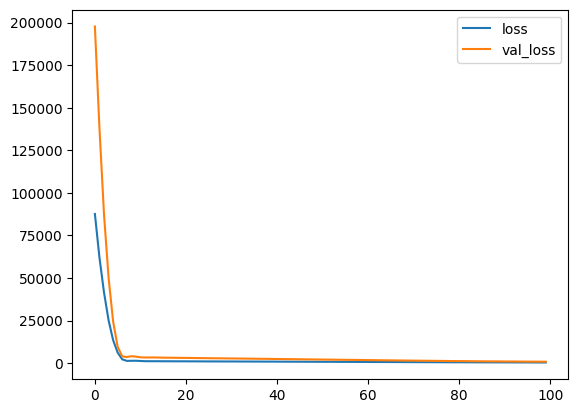

In [18]:
loss_df[['loss', 'val_loss']].plot(legend=True)
plt.show()

## One step ahead forecast

At each point in time (either in train or test set) we have access to the past Tx lags actual observations.

In [19]:
train_indicator[:Tx] = False # the first Tx values are not predictable.
# because we need Tx lags to predict the next value

In [20]:
# making predictions with model_DNN
DNN_1step_train_forecast = model_DNN.predict(Xtrain)
DNN_1step_test_forecast = model_DNN.predict(Xtest)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step


In [21]:
DNN_1step_train_forecast.shape

(108, 1)

In [22]:
DNN_1step_test_forecast.shape

(24, 1)

In [23]:
# plotting one step ahead forecast

data.loc[train_indicator, '1step_train_forecast'] = DNN_1step_train_forecast
data.loc[test_indicator, '1step_test_forecast'] = DNN_1step_test_forecast
data.head(15)

,Passengers,1step_train_forecast,1step_test_forecast
Month,,,
1949-01-01,112,NaN,NaN
1949-02-01,118,NaN,NaN
1949-03-01,132,NaN,NaN
1949-04-01,129,NaN,NaN
1949-05-01,121,NaN,NaN
1949-06-01,135,NaN,NaN
1949-07-01,148,NaN,NaN
1949-08-01,148,NaN,NaN
1949-09-01,136,NaN,NaN


In [24]:
data.tail()

,Passengers,1step_train_forecast,1step_test_forecast
Month,,,
1960-08-01,606,NaN,578.028625
1960-09-01,508,NaN,524.515320
1960-10-01,461,NaN,479.752106
1960-11-01,390,NaN,455.049896
1960-12-01,432,NaN,419.825714


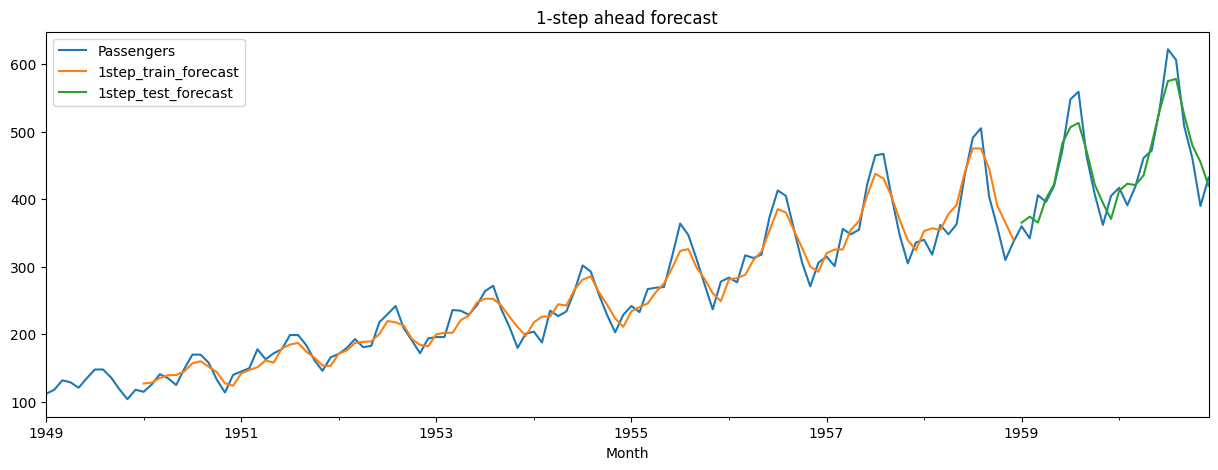

In [25]:
# plot 1-step forecast
data[['Passengers', '1step_train_forecast', '1step_test_forecast']].plot(figsize=(15, 5))
plt.title('1-step ahead forecast')
plt.show()


## Multi-step Forecast

At each point in time, we have access to the Tx lag observations only in the train set. For the test set however, we need to create the lag terms based on previous predictions, that's why we cannot use model.fit(X_test) for multi-step predictions. We need to generate a sequence of predictions for test_period steps into the future.

These predictions can then be used to evaluate the performance of the model over this period.

In [26]:
multistep_predictions = []

# first test input
input_X = Xtest[0]

# Start a loop that will continue until we have the desired number of future forecasts (test_period).
while len(multistep_predictions) < test_period:
  prediction = model_DNN.predict(input_X.reshape(1, -1))[0]

  # update the predictions list
  multistep_predictions.append(prediction)

  # update the new input
  # The input_X array, which serves as input for the next prediction, is updated. The np.roll(input_X, -1) shifts all elements of input_X one position to the left.
  # The last element of last_x, which is now freed up, is filled with the last prediction p.
  input_X = np.roll(input_X, -1)
  input_X[-1] = prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


In [27]:
# save multi-step forecast to dataframe
data.loc[test_indicator, 'multistep_test_forecast'] = multistep_predictions
data.tail()

,Passengers,1step_train_forecast,1step_test_forecast,multistep_test_forecast
Month,,,,
1960-08-01,606,NaN,578.028625,528.280334
1960-09-01,508,NaN,524.515320,502.306427
1960-10-01,461,NaN,479.752106,477.581482
1960-11-01,390,NaN,455.049896,464.214844
1960-12-01,432,NaN,419.825714,463.520142


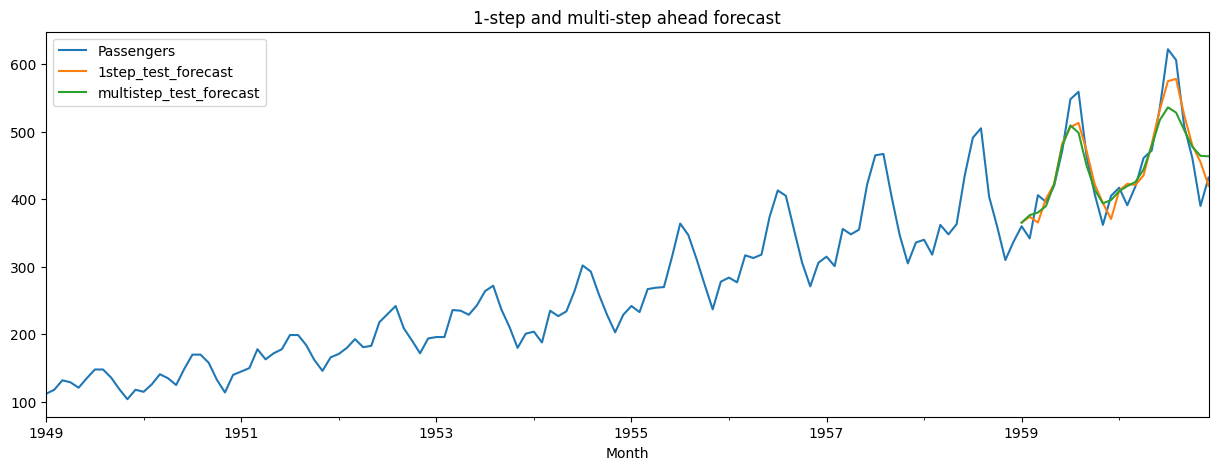

In [28]:
# plot 1-step and multi-step forecast
data[['Passengers', '1step_test_forecast', 'multistep_test_forecast']].plot(figsize=(15, 5))
plt.title('1-step and multi-step ahead forecast')
plt.show()


# Multi-output forecast

In [29]:
# Make multi-output supervised dataset
Tx = 12 # recall: using the past Tx lag observations to forecast the next one.
Ty = test_period # number of outputs forecasted at once

# Create input-output pairs
X = np.array([series[t:t+Tx] for t in range(len(series) - Tx - Ty+1)])
Y = np.array([series[t+Tx:t+Tx+Ty] for t in range(len(series) - Tx - Ty+1)])
N = len(X)

print("X:", X.shape, "Y:", Y.shape, "N:", N)


X: (109, 12) Y: (109, 24) N: 109


In [30]:
Xtrain_mo, Ytrain_mo = X[:-1], Y[:-1]
Xtest_mo, Ytest_mo = X[-1:], Y[-1:] # this is the last observation from data which we use to forecast the future

In [31]:
# print the shapes
print(Xtrain_mo.shape, Ytrain_mo.shape, Xtest_mo.shape, Ytest_mo.shape)

(108, 12) (108, 24) (1, 12) (1, 24)


In [32]:
#Tx = 12 # number of lags
#Ty = 24 # number of outputs forecasted at once
model_DNN_mo = build_model(Tx, Ty)
model_DNN_mo.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 12)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │             416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 24)                  │             408 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,352 (5.28 KB)

 Trainable params: 1,352 (5.28 KB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_DNN_mo.fit(Xtrain_mo, Ytrain_mo, epochs=200, batch_size=16, validation_data=(Xtest_mo, Ytest_mo))


Epoch 1/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 122144.8672 - val_loss: 231136.7188
Epoch 2/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 110035.7734 - val_loss: 209244.4688
Epoch 3/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 88809.5703 - val_loss: 193347.0938
Epoch 4/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 85446.6641 - val_loss: 181604.8750
Epoch 5/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 80018.6406 - val_loss: 170256.2656
Epoch 6/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 73870.6328 - val_loss: 158711.7500
Epoch 7/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 70346.4062 - val_loss: 146129.7031
Epoch 8/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 61246.9258 - val_loss: 133360.9062
Epoch 9/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 54729.6250 - val_loss: 120607.4609
Epoch 10/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 48104.9062 - val_loss: 107910.6797
Epoch 11/200
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 43305.1172 - va

In [34]:
loss_df = pd.DataFrame(model_DNN_mo.history.history)
loss_df.head()

,loss,val_loss
0,112325.664062,231136.718750
1,100289.289062,209244.468750
2,90579.648438,193347.093750
3,84258.054688,181604.875000
4,78647.015625,170256.265625


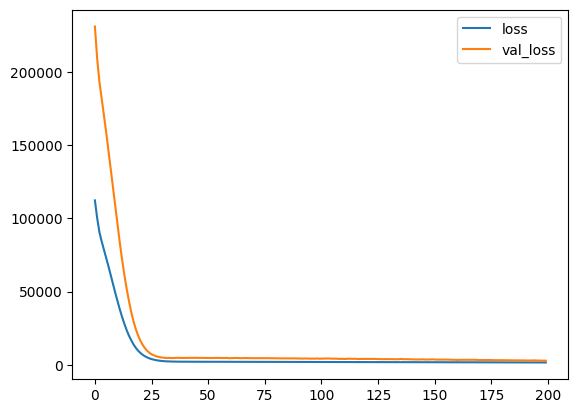

In [35]:
# visualize the loss
loss_df[['loss', 'val_loss']].plot(legend=True)
plt.show()

In [36]:
# making predictions with model_DNN_mo
DNN_mo_train_forecast = model_DNN_mo.predict(Xtrain_mo)
DNN_mo_test_forecast = model_DNN_mo.predict(Xtest_mo) # because we are forecasting multi-output at once, we can use the model.predict(X_test)

# printing the shapes
print(DNN_mo_train_forecast.shape, DNN_mo_test_forecast.shape)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
(108, 24) (1, 24)


In [37]:
DNN_mo_test_forecast

array([[330.2459 , 355.05444, 401.02448, 427.60175, 460.48074, 455.4085 ,
        484.3953 , 442.6382 , 505.0257 , 431.30774, 424.5619 , 389.9385 ,
        392.67822, 373.1116 , 474.60538, 452.9891 , 468.0865 , 501.42932,
        514.95734, 502.20612, 481.05353, 502.64294, 485.91452, 446.87518]],
      dtype=float32)

In [38]:
# save multi-output forecast to dataframe
data.loc[test_indicator, 'multioutput_test_forecast'] = DNN_mo_test_forecast[0]
data.tail()

,Passengers,1step_train_forecast,1step_test_forecast,multistep_test_forecast,multioutput_test_forecast
Month,,,,,
1960-08-01,606,NaN,578.028625,528.280334,502.206116
1960-09-01,508,NaN,524.515320,502.306427,481.053528
1960-10-01,461,NaN,479.752106,477.581482,502.642944
1960-11-01,390,NaN,455.049896,464.214844,485.914520
1960-12-01,432,NaN,419.825714,463.520142,446.875183


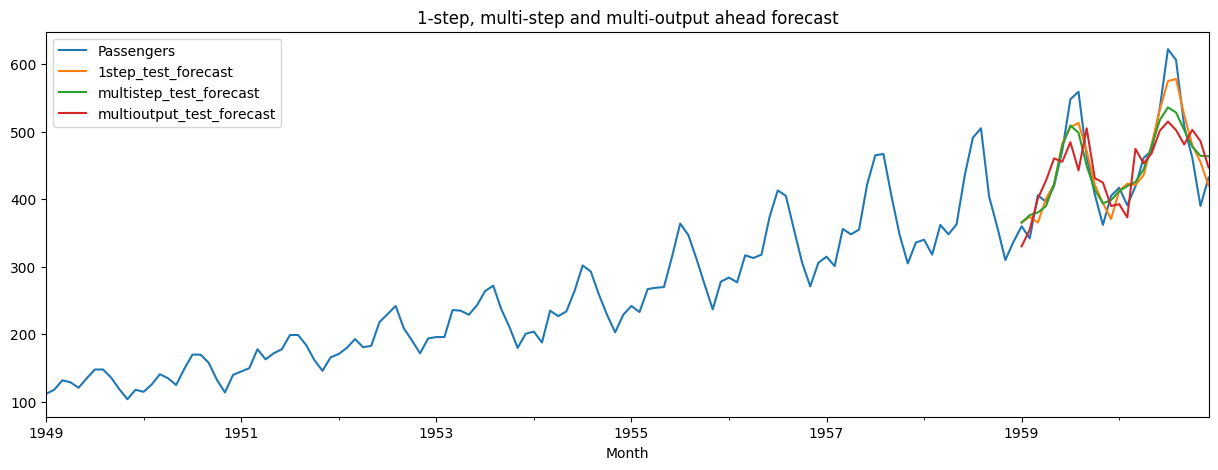

In [39]:
# plot 1-step and multi-step forecast along with multi-output forecast
data[['Passengers', '1step_test_forecast', 'multistep_test_forecast', 'multioutput_test_forecast' ]].plot(figsize=(15, 5))
plt.title('1-step, multi-step and multi-output ahead forecast')
plt.show()

# Forecast comparison

In [40]:
# MAPE
from sklearn.metrics import mean_absolute_percentage_error

passenger_test = data.loc[test_indicator, 'Passengers']
mape1 = mean_absolute_percentage_error(passenger_test, data.loc[test_indicator, '1step_test_forecast'])
mape2 = mean_absolute_percentage_error(passenger_test, data.loc[test_indicator, 'multistep_test_forecast'])
mape3 = mean_absolute_percentage_error(passenger_test, data.loc[test_indicator, 'multioutput_test_forecast'])
print("1step_test MAPE:", mape1)
print("multi-step MAPE:", mape2)
print("multi-output MAPE:", mape3)

1step_test MAE: 0.05009677332681792
multi-step MAE: 0.05439843550285304
multi-output MAE: 0.0883942916704346


## DL_ts_forecaster

In [41]:
# putting everything together for the one-step and multi-step forecasts in a function

# creating the DNN model using functional API and build model function.
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


def dl_ts_forecaster(data, target, lags, fh, model_name='DNN'):

    series = data[target].dropna().to_numpy()

    Tx = lags
    Ty = 1 #  Forecasting Ty step ahead

    # Splitting the data
    test_period = fh
    train_period = len(data) - test_period
    train = data.iloc[:train_period]
    test = data.iloc[train_period:]

    # boolean series for train and test
    train_indicator = (data.index <= train.index[-1])
    test_indicator =  (data.index > train.index[-1])
    train_indicator[:Tx] = False # the first Tx values are not predictable.

    # making supervised data
    X = np.array([series[t:t+Tx] for t in range(len(series) - Tx-Ty+1)])
    Y = np.array([series[t+Tx+Ty-1] for t in range(len(series) - Tx-Ty+1)])
    Xtrain, Ytrain = X[:-test_period], Y[:-test_period]
    Xtest, Ytest = X[-test_period:], Y[-test_period:]

    # training the model
    i = Input(shape=(Tx,))
    x = Dense(32, activation='relu')(i)
    x = Dense(16, activation='relu')(x)
    output = Dense(Ty , activation = 'linear')(x)
    model = Model(i, output)
    model.compile(loss='mse', optimizer='adam')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10)
    model.fit(Xtrain, Ytrain, epochs=100, batch_size=16, validation_data=(Xtest, Ytest))

    # one-step ahead forecast
    data.loc[train_indicator, f'{model_name}_1step_train_forecast'] = model.predict(Xtrain)
    data.loc[test_indicator, f'{model_name}_1step_test_forecast'] = model.predict(Xtest)

    # multi-step ahead forecast
    multistep_predictions = []
    input_X = Xtest[0]
    while len(multistep_predictions) < test_period:
        prediction = model.predict(input_X.reshape(1, -1))[0]
        multistep_predictions.append(prediction)
        input_X = np.roll(input_X, -1)
        input_X[-1] = prediction

    data.loc[test_indicator, f'{model_name}_multistep_test_forecast'] = multistep_predictions

    # MAPE comparison
    mape_1step = mean_absolute_percentage_error(data.loc[test_indicator, target], data.loc[test_indicator, f'{model_name}_1step_test_forecast'])
    mape_multiple_step = mean_absolute_percentage_error(data.loc[test_indicator, target], data.loc[test_indicator, f'{model_name}_multistep_test_forecast'])
    print(f"{model_name} 1-step MAPE:", mape_1step)
    print(f"{model_name} multi-step MAPE:", mape_multiple_step)

    # plot 1-step and multi-step forecast
    data[[target, f'{model_name}_1step_test_forecast', f'{model_name}_multistep_test_forecast']].plot(figsize=(15, 5))
    plt.title('1-step and multi-step ahead forecast')
    plt.show()

    return data

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - loss: 42227.7422 - val_loss: 3618.4333
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3684.0537 - val_loss: 22765.5059
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7622.7212 - val_loss: 3832.0750
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1459.7310 - val_loss: 7066.4585
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2501.2473 - val_loss: 3230.4990
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 928.5091 - val_loss: 3535.1589
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1424.6079 - val_loss: 2669.7021
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 797.6149 - val_loss: 2476.6379
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 795.2464 - val_loss: 2291.9756
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 833.7477 - val_loss: 2093.2610
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1192.2262 - val_loss: 1913.6899
Epoch 12/100
7/7 ━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
DNN 1-step MAPE: 0.036942863834270596
DNN multi-step MAPE: 0.03882525599390564


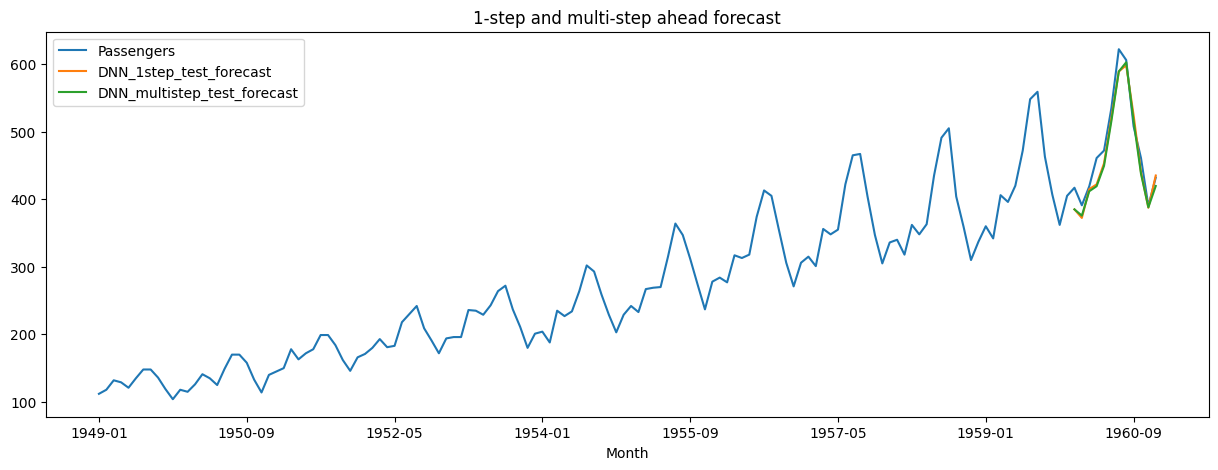

,Passengers,DNN_1step_train_forecast,DNN_1step_test_forecast,DNN_multistep_test_forecast
Month,,,,
1949-01,112,NaN,NaN,NaN
1949-02,118,NaN,NaN,NaN
1949-03,132,NaN,NaN,NaN
1949-04,129,NaN,NaN,NaN
1949-05,121,NaN,NaN,NaN
...,...,...,...,...
1960-08,606,NaN,598.153870,602.656555
1960-09,508,NaN,524.515076,516.024841
1960-10,461,NaN,440.271210,437.810699


In [42]:
df = pd.read_csv("https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/airline_passengers.csv", index_col="Month")
dl_ts_forecaster(data=df, target='Passengers', lags=24, fh=12)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - loss: 0.1627 - val_loss: 0.0204
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0386 - val_loss: 0.0403
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0291 - val_loss: 0.0169
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0114 - val_loss: 0.0192
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105 - val_loss: 0.0067
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0086 - val_loss: 0.0063
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0078
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - val_loss: 0.0067
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0072 - val_loss: 0.0062
Epoch 10/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0055 - val_loss: 0.0061
Epoch 11/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0079 - val_loss: 0.0067
Epoch 12/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - val_loss: 0.0077

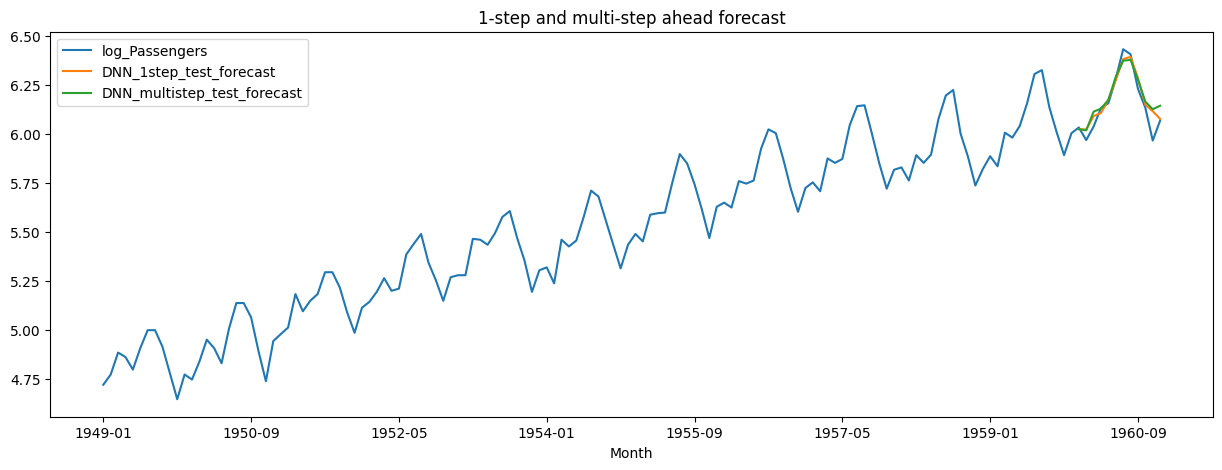

,Passengers,log_Passengers,DNN_1step_train_forecast,DNN_1step_test_forecast,DNN_multistep_test_forecast
Month,,,,,
1949-01,112,4.718499,NaN,NaN,NaN
1949-02,118,4.770685,NaN,NaN,NaN
1949-03,132,4.882802,NaN,NaN,NaN
1949-04,129,4.859812,NaN,NaN,NaN
1949-05,121,4.795791,NaN,NaN,NaN
...,...,...,...,...,...
1960-08,606,6.406880,NaN,6.394020,6.378328
1960-09,508,6.230481,NaN,6.285136,6.277329
1960-10,461,6.133398,NaN,6.149210,6.164831


In [43]:
df = pd.read_csv("https://raw.githubusercontent.com/PJalgotrader/Deep_forecasting-USU/main/data/airline_passengers.csv", index_col="Month")
df['log_Passengers'] = np.log(df['Passengers'])
dl_ts_forecaster(data=df, target='log_Passengers', lags=12, fh=12)

# Done!